# Клиенты авиакомпании

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score
)

RANDOM_STATE = 42
DATASET_PATH = "https://raw.githubusercontent.com/evgpat/stepik_from_idea_to_mvp/main/datasets/clients.csv"

In [3]:
# Загрузка данных
df = pd.read_csv(DATASET_PATH)
df.head()

,id,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,...,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,satisfaction
0,1,Male,48.0,disloyal Customer,Business travel,Business,821.0,2.0,5.0,3.0,...,3.0,5.0,5.0,3.0,2.0,5.0,4.0,5.0,5.0,neutral or dissatisfied
1,2,Female,35.0,Loyal Customer,Business travel,Business,821.0,26.0,39.0,2.0,...,5.0,4.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,satisfied
2,3,Male,41.0,Loyal Customer,Business travel,Business,853.0,0.0,0.0,4.0,...,5.0,5.0,3.0,3.0,3.0,3.0,4.0,3.0,5.0,satisfied
3,4,Male,50.0,Loyal Customer,Business travel,Business,1905.0,0.0,0.0,2.0,...,4.0,5.0,5.0,5.0,5.0,5.0,3.0,5.0,4.0,satisfied
4,5,Female,49.0,Loyal Customer,Business travel,Business,3470.0,0.0,1.0,3.0,...,5.0,4.0,3.0,3.0,4.0,3.0,3.0,3.0,5.0,satisfied


In [4]:
# Очистка целевой переменной
df = df[df['satisfaction'].isin(['satisfied', 'neutral or dissatisfied'])]
df['satisfaction'] = df['satisfaction'].map({
'satisfied': 1,
'neutral or dissatisfied': 0
})

In [5]:
# Разделение на train / test
X = df.drop(['id', 'satisfaction'], axis=1)
y = df['satisfaction']


X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

In [6]:
# Вспомогательные функции очистки

def cap_outliers(series, q_low=0.01, q_high=0.99):
  low, high = series.quantile([q_low, q_high])
  return series.clip(low, high)

In [7]:
# Обработка числовых признаков

num_cols = [
'Age',
'Flight Distance',
'Departure Delay in Minutes',
'Arrival Delay in Minutes'
]

for col in num_cols:
  X_train[col] = cap_outliers(X_train[col])
  med = X_train[col].median()
  X_train[col] = X_train[col].fillna(med)
  X_test[col] = X_test[col].fillna(med)

In [8]:
# Обработка сервисных оценок

service_cols = [
'Inflight wifi service', 'Departure/Arrival time convenient',
'Ease of Online booking', 'Gate location', 'Food and drink',
'Online boarding', 'Seat comfort', 'Inflight entertainment',
'On-board service', 'Leg room service', 'Baggage handling',
'Checkin service', 'Inflight service', 'Cleanliness'
]

for col in service_cols:
    med = X_train[col].median()
    X_train[col] = X_train[col].fillna(med)
    X_test[col] = X_test[col].fillna(med)

    X_train[col] = X_train[col].clip(0, 5)
    X_test[col] = X_test[col].clip(0, 5)

In [9]:
# Категориальные признаки

cat_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class']

for col in cat_cols:
  mode = X_train[col].mode()[0]
  X_train[col] = X_train[col].fillna(mode)
  X_test[col] = X_test[col].fillna(mode)

X_train['Gender'] = X_train['Gender'].map({'Male': 0, 'Female': 1})
X_test['Gender'] = X_test['Gender'].map({'Male': 0, 'Female': 1})

X_train['Customer Type'] = X_train['Customer Type'].map({'Loyal Customer': 1, 'disloyal Customer': 0})
X_test['Customer Type'] = X_test['Customer Type'].map({'Loyal Customer': 1, 'disloyal Customer': 0})

X_train['Type of Travel'] = X_train['Type of Travel'].map({'Business travel': 1, 'Personal Travel': 0})
X_test['Type of Travel'] = X_test['Type of Travel'].map({'Business travel': 1, 'Personal Travel': 0})

X_train = pd.get_dummies(X_train, columns=['Class'], dtype=int)
X_test = pd.get_dummies(X_test, columns=['Class'], dtype=int)

X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [10]:
# Модель

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

pipe.fit(X_train, y_train)

,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [11]:
# Оценка качества

pred = pipe.predict(X_test)
proba = pipe.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print('ROC-AUC', roc_auc_score(y_test, proba))

[[13291  1429]
 [ 1855  9401]]
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     14720
           1       0.87      0.84      0.85     11256

    accuracy                           0.87     25976
   macro avg       0.87      0.87      0.87     25976
weighted avg       0.87      0.87      0.87     25976

ROC-AUC 0.9240782210840208


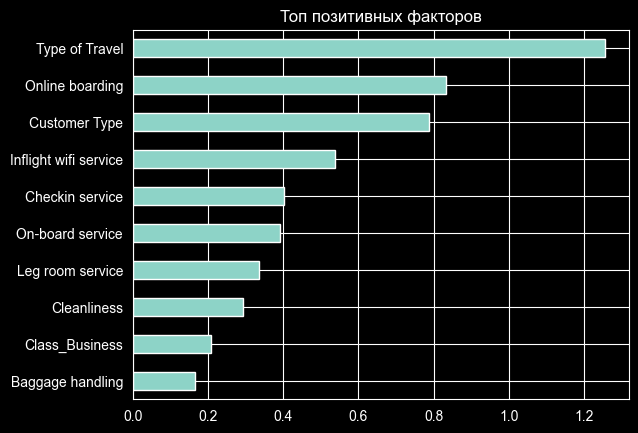

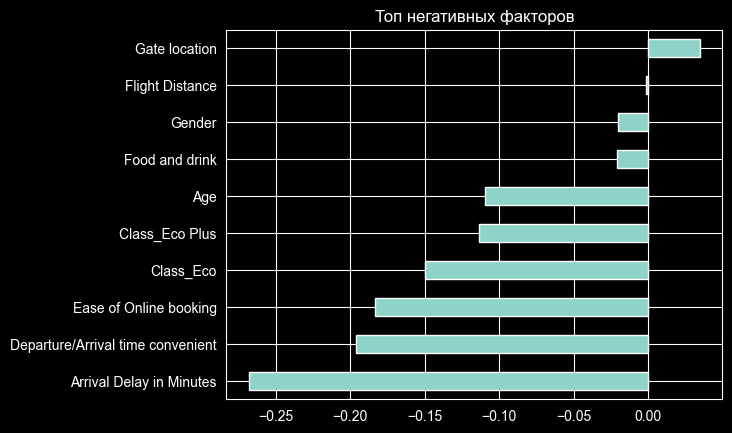

In [12]:
# Feature Importance

import pandas as pd

coef = pipe.named_steps['model'].coef_[0]
features = X_train.columns

importance = pd.Series(coef, index=features).sort_values()
importance


importance.tail(10).plot(kind='barh', title='Топ позитивных факторов')
plt.show()

importance.head(10).plot(kind='barh', title='Топ негативных факторов')
plt.show()

In [13]:
# Улучшение качества модели

# RandomForest

from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(
n_estimators=300,
max_depth=12,
random_state=RANDOM_STATE,
n_jobs=-1
)


rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:, 1]


print(classification_report(y_test, rf_pred))
print('ROC-AUC:', roc_auc_score(y_test, rf_proba))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     14720
           1       0.95      0.93      0.94     11256

    accuracy                           0.95     25976
   macro avg       0.95      0.95      0.95     25976
weighted avg       0.95      0.95      0.95     25976

ROC-AUC: 0.9910054553030654


In [14]:
# Production-ready preprocessing

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


num_cols = X.select_dtypes(include=np.number).columns.tolist()
class_cols = [col for col in X.columns if col.startswith('Class_')]
cat_cols = ['Gender', 'Customer Type', 'Type of Travel'] + class_cols


preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(), cat_cols)
])


pipe_prod = Pipeline([
('prep', preprocessor),
('model', LogisticRegression(max_iter=1000))
])


pipe_prod.fit(X_train, y_train)

,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [16]:
# Сохранение модели

import joblib

joblib.dump(pipe_prod, 'airline_satisfaction_model.pkl')

['airline_satisfaction_model.pkl']